**Gustavo Recalde | Proyecto Portafolio de inversiones**



## INTRODUCCIÓN

La predicción del precio de las acciones constituye un aspecto crítico en la gestión de portafolios de inversión, siendo la toma de decisiones informadas la condición mas importante para el éxito en los mercados bursátiles. En este contexto, el presente trabajo aborda el desarrollo de un modelo predictivo como parte de una investigación preliminar para la tesis sobre estrategias de inversión en bolsa. El objetivo es examinar la viabilidad de aplicar métodos de regresión regularizada para estimar los precios de cierre futuros, utilizando como caso de estudio las acciones de Google (GOOGL).

El trabajo en esta noteboock ue centrado inicialmente en la recopilación de datos históricos desde la plataforma yahoo finance.
El plan de trabajo fue seguir el esquema prouesto mediante pipelines, implementado la tecnica de información mutua para feature selection, se comparó los modelos de regresión lineal regularizada Ridge y Lasso usando un test de hiótesis con repeated k-fold cross validation.
Se comprobo mediante graficas el comportamiento de los modeloes empleados, curvas de aprenidzaje, la tecnica de visualización TSNE y los resulatdos de las prediciones versus los datos reales.

A través de una serie de pruebas de validación y evaluación en conjuntos de datos separados, se obtuvieron resultados que sugieren una correspondencia prometedora entre las predicciones de los modelos y los precios reales de cierre. Aunque estos hallazgos son preliminares, proporcionan una base para refinar a metodologías que usaré para el proyecto de tésis


## Importar librerías y cargar datos
Usamos datos de cualquiera de los tickers de interes, que son las siglas que representan a los mercados. (ejemplo: GOOGL = Google)
Usaremos incialemente los datos de un periodo de 2 años

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import yfinance as yf

In [50]:
ticker = "GOOGL"
#Período de los datos
inicio = "2017-01-01"
fin = "2020-01-01"
data = yf.download(ticker, start=inicio, end=fin)

data_path = "GOOGL_20170101_20200101.csv"
data.to_csv(data_path)
data = pd.read_csv(data_path)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000
1,2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000
2,2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000
3,2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000
4,2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000


Vamos a definir como variable predictoria, el precio de cierre del siguiente día en base al comportamiento del día anterior, por lo que es necesario aumentar una columna adicionales con el precio de cierre del sigguiente día.

In [51]:
# Crear columnas desplazadas
data['Next_Close'] = data['Close'].shift(-1)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Next_Close
0,2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,40.388500
1,2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,40.651001
2,2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,41.260502
3,2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,41.359001
4,2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,41.300499


## Feature Selection
Implementamos una técnica de feature selection con información mutua en nuestro pipeline

In [52]:
# Preparar los datos: eliminar filas con valores faltantes para simplificar
data_clean = data.dropna()

# Seleccionar solo columnas numéricas
numeric_data = data_clean.select_dtypes(include=[np.number])

# Configurar el pipeline de selección de características usando información mutua
feature_selection_pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_regression, k=3))
])

# Ajustar el pipeline al conjunto de datos
X = numeric_data.drop('Next_Close', axis=1)  # Asumimos que queremos predecir 'Close'
y = numeric_data['Next_Close']
feature_selection_pipeline.fit(X, y)

# Obtener los scores de las características seleccionadas
feature_scores = feature_selection_pipeline.named_steps['feature_selection'].scores_

# Crear un DataFrame para visualizar mejor los nombres de las características y sus scores
features_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})
print(features_scores_df.sort_values(by='Score', ascending=False))

     Feature     Score
4  Adj Close  2.153925
3      Close  2.153804
2        Low  2.079267
1       High  2.026833
0       Open  1.895070
5     Volume  0.027289


In [53]:
X.head()

,Open,High,Low,Close,Adj Close,Volume
0,40.030998,40.571999,39.844501,40.400501,40.400501,39180000
1,40.494499,40.671501,40.205502,40.388500,40.388500,30306000
2,40.375000,40.687000,40.296001,40.651001,40.651001,26810000
3,40.749500,41.448002,40.575001,41.260502,41.260502,40342000
4,41.318501,41.521500,41.081001,41.359001,41.359001,28178000


Descartamos unicamente la variale volumen por ser la menos representativa y Adj. Close que en este caso asumimos es el mismo valor que close.

## Comparación de regresión Lineal Regularizada Ridge vs Lasso


In [54]:
from scipy.stats import ttest_rel

X = X.drop(['Volume', 'Adj Close'], axis=1)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los pipelines para Ridge y Lasso
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1))
])

# Configurar la validación cruzada repetida
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

# Entrenar y evaluar los modelos usando validación cruzada repetida
scores_ridge = cross_val_score(pipeline_ridge, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_lasso = cross_val_score(pipeline_lasso, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# Convertir las puntuaciones a un formato positivo (para MSE, menor es mejor)
scores_ridge = -scores_ridge
scores_lasso = -scores_lasso

print(f'MSE Ridge= {scores_ridge.mean()}')
print(f'MSE Lasso= {scores_lasso.mean()}')

# Entrenar modelos con el conjunto completo de entrenamiento y evaluar en el conjunto de prueba
pipeline_ridge.fit(X_train, y_train)
pipeline_lasso.fit(X_train, y_train)

mse_ridge = mean_squared_error(y_test, pipeline_ridge.predict(X_test))
mse_lasso = mean_squared_error(y_test, pipeline_lasso.predict(X_test))

print(f'MSE Ridge en prueba: {mse_ridge}')
print(f'MSE Lasso en prueba: {mse_lasso}')

# Realizar el test de hipótesis para comparar los modelos
stat, p = ttest_rel(scores_ridge, scores_lasso)
print(f"T-test stat: {stat}, p-value: {p}")


MSE Ridge= 0.6422623925720246
MSE Lasso= 0.6501719985536418
MSE Ridge en prueba: 0.5456741868580085
MSE Lasso en prueba: 0.5662753468164485
T-test stat: -4.678506068847438, p-value: 9.169342225777303e-06


## Visualización con TSNE

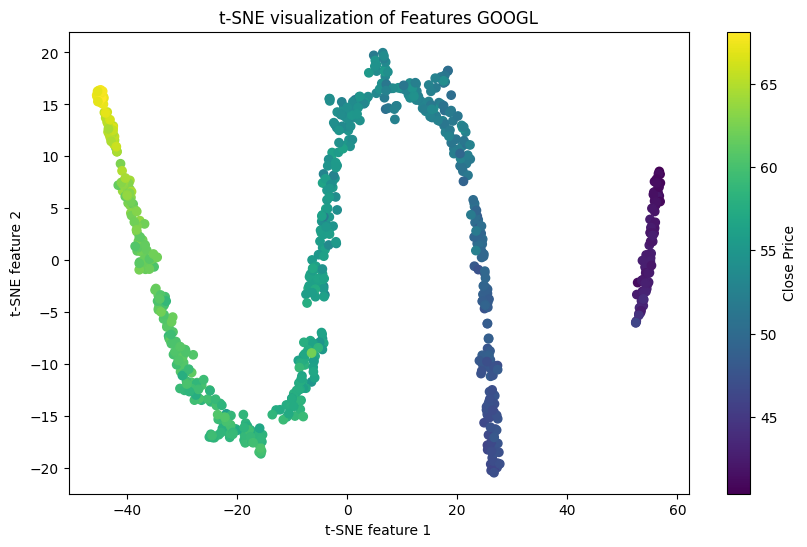

In [55]:
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X)

# Usar TSNE para reducir la dimensión a 2D para visualización
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualizar
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar(label='Close Price')
plt.title(f't-SNE visualization of Features {ticker}')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


 La progresión del color a lo largo de las agrupaciones muestra una correlación entre la estructura de los datos en el espacio de características reducido y el precio de cierre de las acciones. Por ejemplo, si observamos una transición suave de un color a otro a lo largo de una secuencia de puntos, esto indicaria que cambios graduales en las características están asociados con cambios en el precio de cierre.
 Las regiones donde puntos de colores similares están cercanos podrían representar periodos en los que el mercado mostró comportamientos consistentes en términos de los factores que determinan el precio de cierre. Por otro lado, los puntos donde el color cambia rápidamente podrían representar periodos de transición o de volatilidad en el mercado.

## Optimización de hiperpámetros

Mejor alpha: 0.5689866029018293


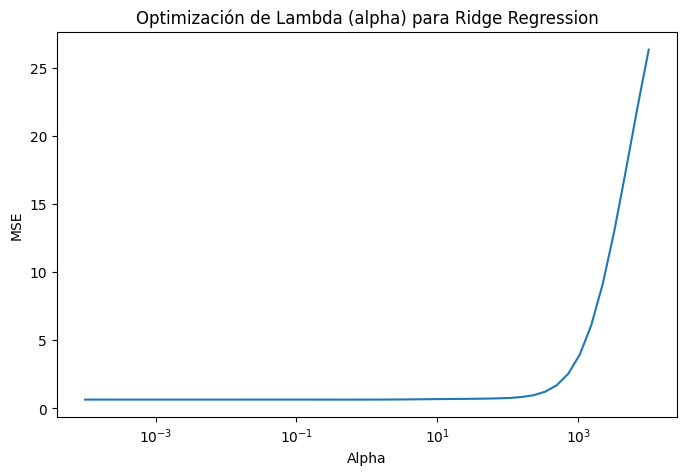

In [56]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de lambda (alpha)
param_grid = {'ridge__alpha': np.logspace(-4, 4, 50)}

# Optimización de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(pipeline_ridge, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
grid_search.fit(X, y)

# Mejor lambda (alpha)
print(f"Mejor alpha: {grid_search.best_params_['ridge__alpha']}")

# Gráfica de optimización de lambda
alphas = np.logspace(-4, 4, 50)
scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, -scores)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Optimización de Lambda (alpha) para Ridge Regression')
plt.show()


## Curvas de aprendizaje

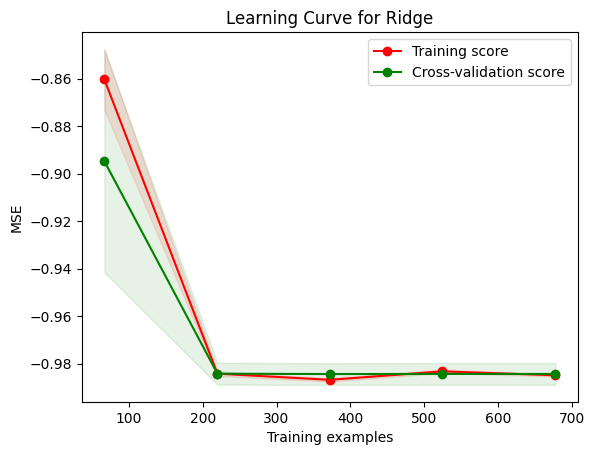

In [57]:
from sklearn.model_selection import learning_curve
#Curva para Ridge
train_sizes, train_scores, test_scores = learning_curve(
    pipeline_ridge,
    X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calcular las medias y desviaciones estándar del score de entrenamiento y de prueba
train_scores_mean = -np.mean(train_scores, axis=1)  # Convertimos los scores a positivos para el MSE
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)  # Convertimos los scores a positivos para el MSE
test_scores_std = np.std(test_scores, axis=1)

# Dibujar las curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("MSE")
plt.title('Learning Curve for Ridge')
plt.legend(loc="best")
plt.show()

La curva de aprendizaje para el modelo Ridge muestra que, inicialmente, con pocos datos de entrenamiento, el modelo tiene un bajo rendimiento, reflejado en un MSE alto. A medida que se introducen más datos, el modelo mejora, lo que se evidencia por la reducción del MSE de entrenamiento. La disminución en la brecha entre las curvas de entrenamiento y de validación cruzada indica que el modelo está ganando capacidad de generalización y reduce el riesgo de sobreajuste. Finalmente, se observa una estabilización en el rendimiento, lo que podría indicar que se ha alcanzado la capacidad máxima de aprendizaje del modelo con la estructura y los datos actuales. La variabilidad de los resultados en la validación cruzada se reduce con el aumento de los datos, sugiriendo una mejor fiabilidad del modelo.

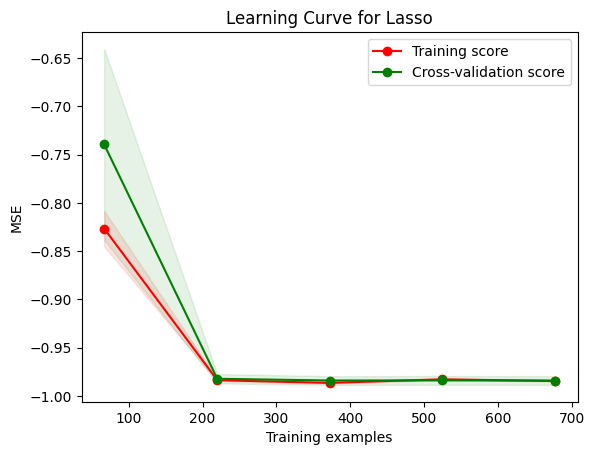

In [58]:
#Curva para Lasso
train_sizes, train_scores, test_scores = learning_curve(
    pipeline_lasso,
    X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calcular las medias y desviaciones estándar del score de entrenamiento y de prueba
train_scores_mean = -np.mean(train_scores, axis=1)  # Convertimos los scores a positivos para el MSE
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)  # Convertimos los scores a positivos para el MSE
test_scores_std = np.std(test_scores, axis=1)

# Dibujar las curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("MSE")
plt.title('Learning Curve for Lasso')
plt.legend(loc="best")
plt.show()

AL igual que el modeloo ridge,el comportamiento es muy similar y solo varía en que el MSE es menor al anterior por lo que podriamos optar por esoger el modelo ridge.

## Entrenamiento del modelo con los mejores parámetros

In [59]:
# Asignamos el mejor alpha encontrado por GridSearchCV
best_alpha = grid_search.best_params_['ridge__alpha']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utilizar X_train y y_train para la optimización de hiperparámetros y entrenamiento
grid_search = GridSearchCV(pipeline_ridge, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Definimos el pipeline con el mejor modelo Ridge usando el mejor alpha
best_ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha))
])

# Entrenamos el mejor pipeline de Ridge con el conjunto completo de datos
best_ridge_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.5689866029018293))])

In [60]:

r_squared_train = best_ridge_pipeline.score(X, y)
print(f"R-squared on Training Data: {r_squared_train}")

R-squared on Training Data: 0.9849452577246266


$R^2$ bastante alto, podria parecer un sobreajuste.

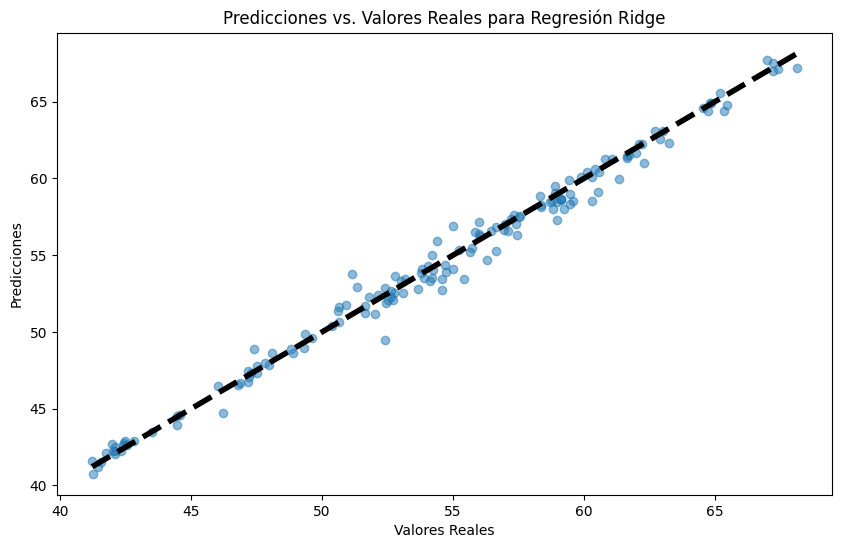

In [61]:
# dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
pipeline_ridge.fit(X_train, y_train)

# Hacer predicciones
y_pred = pipeline_ridge.predict(X_test)

# Graficar las predicciones en comparación con los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Una línea para la predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales para Regresión Ridge')
plt.show()

[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 3.0681674632248024


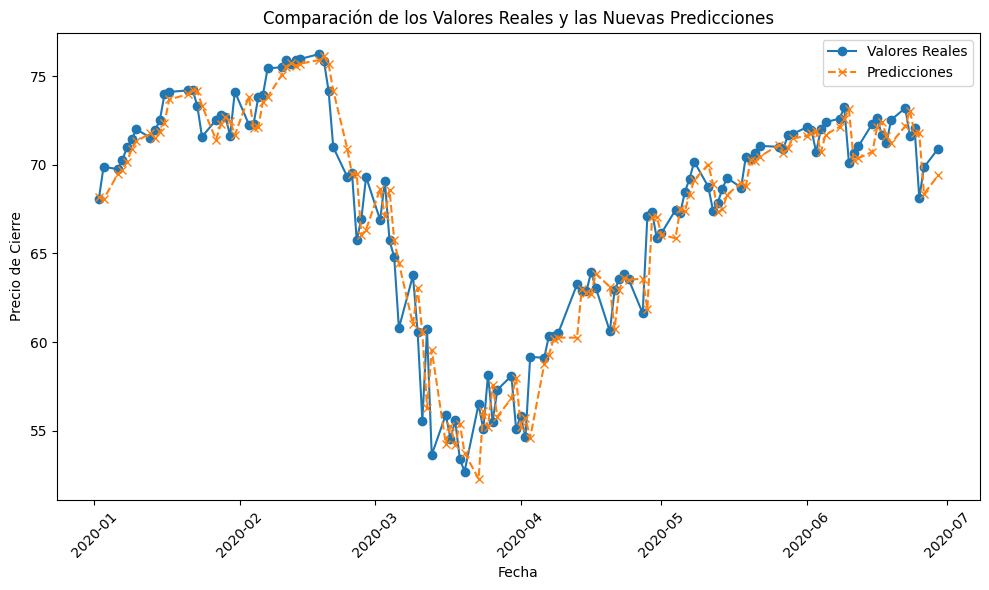

In [62]:
# Descargar nuevos datos
ticker = "GOOGL"
inicio = "2020-01-02"
fin = "2020-07-01"
nuevos_datos = yf.download(ticker, start=inicio, end=fin)

# Asegurarse de que 'Date' sea una columna
nuevos_datos.reset_index(inplace=True)

# Preparar los nuevos datos añadiendo las características 'Prev_Open' y 'Prev_Close'
nuevos_datos['Next_Close'] = nuevos_datos['Close'].shift(-1)


# Eliminar filas con valores NaN que puedan haber sido introducidos por el uso de shift
nuevos_datos = nuevos_datos.dropna()

# Crear el conjunto de características para la predicción
X_new = nuevos_datos.drop(['Next_Close', 'Volume', 'Adj Close', 'Date'], axis=1)

# Usar el modelo entrenado para hacer predicciones con los nuevos datos
y_pred_new = best_ridge_pipeline.predict(X_new)

# Opcionalmente, calcular métricas de error si también tienes los valores reales de cierre disponibles
y_new = nuevos_datos['Next_Close'].values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_new, y_pred_new)
print(f'Mean Squared Error: {mse}')

# Graficar los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(nuevos_datos['Date'], y_new, label='Valores Reales', marker='o', linestyle='-')
plt.plot(nuevos_datos['Date'], y_pred_new, label='Predicciones', marker='x', linestyle='--')
plt.title('Comparación de los Valores Reales y las Nuevas Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Conclusión

Siguiendo el esquema de trabajo empleado, a continuación podemos tener las siguientes conclusiones:


Debido a la característcoa de los datos, y la informaicón necesaria para la predicción, no reducimos el numero de caracterstica, y solo descratamos 2 variables que no aportaban.

**Feature Selection**: Debido a la característica de los datos, y la información necesaria para la predicción, no reducimos el numero de caracterstica, y solo descartamos 2 variables que no aportaban.

**Comparación de Modelos de ML**: Se ejecutó una comparación entre los modelos de aprendizaje automático Ridge y Lasso, revelando diferencias en términos de su capacidad predictiva. El comportamiento de los dos modelos en sus curvas de aprendizaje es similar por lo que el facto de optar por cualquiera de los dos fue el valor de MSE

**Pipelines:** El empleo de pipelines para la secuencia de transformaciones de datos y modelado garantizó la reproducibilidad y la eficiencia operativa. Estos pipelines posibilitaron la estandarización de los pasos de procesamiento y la evaluación de los modelos.

**Visualización de Datos:** La visualización t-SNE revela que la secuencia de colores correlaciona las características de los datos con el precio de cierre, indicando que patrones consistentes en el espacio de características se asocian con comportamientos estables del mercado, mientras que variaciones rápidas en color pueden señalar volatilidad o cambios en el mercado.

**Evaluación de Resultados:** El modelo implementados mostro preliminarmemte una buena capacidad de predicción cosiderando que la simplicidad del modelo, alineando con precisión sus predicciones con los precios de cierre del mercado de acciones. La validez de estos modelos se comprobó mediante su aplicación a nuevos conjuntos de datos, considerando 6 meses adicionales continuos a la data historica, demostrando su buena adaptación.

**Futuro Trabajo:** Un siguiente paso a esta aproximación sería el de explorar mas técnicas de predicción como el uso de medias moviles y modelos SVTM con redes neuronales. Demás, tambien se puede explorar tecnicas de calsificaicon  para predecir si subirá o bajará una acción para un determinado periodo.


## Referencias

[1] "Feature selection: A Complete Guide with Python Scikit-Learn," DataCamp, 2020. [En línea]. Disponible: https://scikit-learn.org/stable/modules/feature_selection.html

[2] "sklearn.model_selection.RepeatedStratifiedKFold: A Complete Guide with Python Scikit-Learn," DataCamp, 2020. [En línea]. Disponible: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#l

[3] "Scikit-learn Pipeline Tutorial with Parameter Tuning and Cross-Validation", 2020. [En línea]. Disponible: https://towardsdatascience.com/scikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb

[4] "Scikit-learn documentation: sklearn.manifold.TSNE," scikit-learn developers, 2021. [En línea]. Disponible: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html.

[5] "Scikit-learn documentation: sklearn.linear_model.Ridge," scikit-learn developers, 2021. [En línea]. Disponible: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html.

[6] "YFinance: Yahoo Finance API," Ran Aroussi, 2020. [En línea]. Disponible: https://pypi.org/project/yfinance/.

[7] "GridSearchCV: Searching for estimator parameters," scikit-learn developers, 2021. [En línea]. Disponible: https://scikit-learn.org/stable/modules/grid_search.html#grid-search.

